# Table of Contents

- [Get the data](#get-the-data)
- [Exploring the data](#exploring-the-data)
- [Analysis of the data before preprocessing](#analysis-of-the-data-before-preprocessing)
- [Preprocessing of the data](#preprocessing-of-the-data)
- [Geographical visualization of the housing prices (by color) and density of population (by marker size)](#geographical-visualization-of-the-housing-prices-(by-color)-and-density-of-population-by-(marker-size))
- [Selection of the best model through cross-validation](#selection-of-the-best-model-through-cross-validation)
- [Predicting the median house values using the best model](#predicting-the-median-house-values-using-the-best-model)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.plotting import scatter_matrix

In [4]:
try:
    import xgboost
except:
    !pip install xgboost
try:
    import lightgbm
except:
    !pip install lightgbm


In [5]:
import os
import urllib.request
import tarfile
from typing import List,Optional,Any,Union,Dict

In [6]:
import sklearn.model_selection
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import  Pipeline

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score



## Get the data

In [22]:
def download_data(url_path: str, folder_path: str, file_path: str) -> None:
    """
    Function: Downloads a compressed data file from a given URL, saves it locally, and extracts its contents.

    Parameters:
    url_path : str
        The URL from which the data file will be downloaded. 
    folder_path : str
        The local directory where the extracted files will be stored. 
        If the folder does not exist, it will be created.

    file_path : str
        The full local path (including the filename) where the downloaded file will be saved.
        Example: "./data/raw_data.tar.gz"

    Returns:
    None
        This function does not return any value. It performs file download, extraction, 
        and prints the names of the extracted files.
    """

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Download the file from the URL
    urllib.request.urlretrieve(url_path, file_path)
    
    # Extract the contents of the compressed file
    with tarfile.open(file_path, "r") as tar:
        for file_name in tar.getnames():
            print(f"Filenames in the zip file are: {file_name}")
        tar.extractall(folder_path)


In [23]:
folder_path=os.path.join("datasets","housing_data")
file_path=os.path.join(folder_path,"housing.tgz")
url_path="https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.tgz"
download_data(url_path=url_path,folder_path=folder_path,file_path=file_path)

Filenames in the zip file are: housing.csv


C:\Users\saiye\AppData\Local\Temp\ipykernel_57116\3466525552.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(folder_path)


In [24]:
def read_data(folder_path: str, file_name: str) -> pd.DataFrame:
    """
    Function: 
        Reads a CSV file from the specified folder path and returns it as a pandas DataFrame.

    Parameters:
    folder_path : str
        The path to the folder where the CSV file is located.

    file_name : str
        The name of the CSV file to be read.

    Returns:
        DataFrame
            A pandas DataFrame containing the data from the CSV file.
    """

    housing_data = os.path.join(folder_path, file_name)
    read_data = pd.read_csv(housing_data)
    return read_data

In [25]:
housing_data=read_data(folder_path=folder_path,file_name="housing.csv")

In [26]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [27]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Exploring the data:


In [28]:
class DataExplorer:
    """
    Process: 
        A class for exploratory data analysis (EDA) to summarize, visualize, and analyze datasets.

    Parameters:

        dataframe : pd.DataFrame
            The pandas DataFrame that will be analyzed.
    Attributes:

        `df : pd.DataFrame
            The original dataset provided during initialization.
        numeric_df : pd.DataFrame
            A subset of the DataFrame containing only numeric columns.
        categorical_df : pd.DataFrame
            A subset of the DataFrame containing only categorical columns.`
    """

    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe
        self.numeric_df = self.df.select_dtypes(include=["number"])
        self.categorical_df = self.df.select_dtypes(include=["object", "category"])

    def summary_data(self) -> None:
        """
        Function: Displays a brief summary of the dataset, which includes 
                    shapes of features,
                    overview of null values present and datatypes of the features
                    overall statistics of the features.
        
        """
        print("====== TOP 5 Rows ======")
        display(self.df.head())

        print("\n=== Shape of the Data ===")
        display(self.df.shape)

        print("\n=== Overview of Null Values and Data Types ===")
        display(self.df.info())

        print("\n=== Descriptive Statistics ===")
        display(self.df.describe())

    def plot_histograms(self, bins: int = 50, figsize: tuple = (20, 10), save_fig: bool = True) -> None:
        """
        Function: Plots histograms for all numeric features in the dataset.

        Parameters
            bins : int, optional (default=50)
                Number of bins for the histogram.
            figsize : tuple, optional (default=(20, 10))
                The size of the figure.
            save_fig : bool, optional (default=True)
                Whether to save the histogram as an image file.
        """
        plt.figure(figsize=figsize)
        self.df.hist(bins=bins, figsize=figsize)
        plt.suptitle("Histograms of Features", fontname="Times New Roman", fontweight='bold', fontsize=16)
        if save_fig:
            plt.savefig("Histograms_of_features.png")
            print("Histogram of features has been saved as 'Histograms_of_features.png'")
        plt.show()

    def pairplot(self, features: Optional[List[str]] = None, x_vars: Optional[List[str]] = None,
                 y_vars: Optional[List[str]] = None, save_fig: bool = True) -> None:
        """
        Function: Creates pairplots (scatterplot matrix) to visualize relationships between features.

        Parameters
            
            features : list of str, optional
                List of column names to include in the pairplot. If None, all features are included.
            x_vars : list of str, optional
                Variables to be plotted on the x-axis.
            y_vars : list of str, optional
                Variables to be plotted on the y-axis.
            save_fig : bool, optional (default=True)
                Whether to save the pairplot as an image file.
        """
        if features is None:
            features = self.df.columns.tolist()

        g = sns.pairplot(self.df[features], x_vars=x_vars, y_vars=y_vars)
        g.fig.suptitle("Pairplot Among the Features", fontname="Times New Roman", fontweight='bold', fontsize=16)
        g.fig.tight_layout()
        plt.show()

        if save_fig:
            g.fig.savefig("scatter_matrix.png", dpi=300, bbox_inches="tight")
            print("Pairplot saved as 'scatter_matrix.png'.")

    def correlation_matrix(self, save_fig: bool = True) -> None:
        """
        Function: Visualizes the correlation matrix among numeric features using a heatmap.

        Parameters:
            save_fig : bool, optional (default=True)
                Whether to save the correlation matrix as an image file.
        """
        self.corr_mat = self.df.corr(numeric_only=True)
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.corr_mat, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
        plt.suptitle("Correlation Matrix", fontname="Times New Roman", fontweight='bold', fontsize=16)
        plt.tight_layout()
        plt.show()

        if save_fig:
            plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")
            print("Correlation matrix saved as 'correlation_matrix.png'.")

    def missing_values_summary(self) -> None:
        """
        Displays a summary of missing values in the dataset, including:
            count of missing values per feature
            total number of rows
            percentage of missing data
        """
        missing_counts = self.df.isnull().sum()
        total_rows = len(self.df)
        missing_info = pd.DataFrame({
            "missing_count": missing_counts,
            "total_count": total_rows,
            "missing_percentage": (missing_counts / total_rows) * 100
        })

        print("\n====== MISSING VALUES SUMMARY ======")
        display(missing_info[missing_info["missing_count"] > 0])

    def categorical_summary(self) -> None:
        """
        Function: Displays the frequency counts of unique values for each categorical feature.
        Returns:
            None
        """
        print("\n====== Categorical Features Summary ======")
        if hasattr(self, "categorical_df"):
            if self.categorical_df.empty:
                print("There are no categorical features in the DataFrame.")
            else:
                for col in self.categorical_df.columns:
                    print(f"====== Categorical Feature: {col} ======")
                    display(self.categorical_df[col].value_counts())
        else:
            print(f"{self.__class__.__name__} does not have the attribute 'categorical_df'.")

====== TOP 5 Rows ======


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



=== Shape of the Data ===


(20640, 10)


=== Overview of Null Values and Data Types ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None


=== Descriptive Statistics ===


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Histogram of features has been saved as 'Histograms_of_features.png'


<Figure size 2000x1000 with 0 Axes>

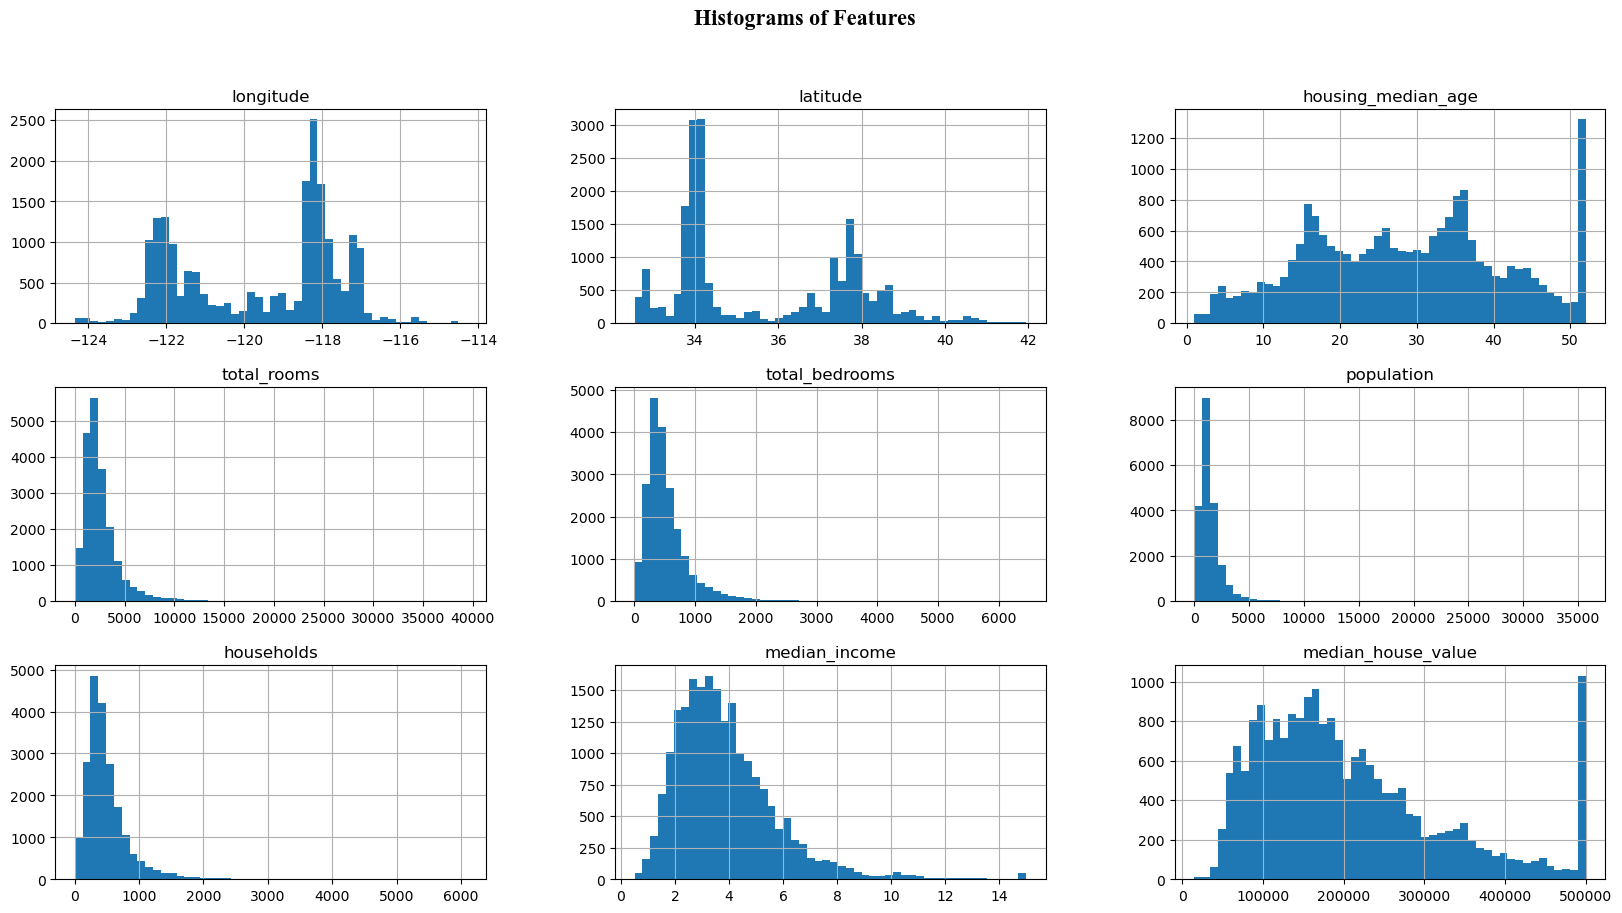

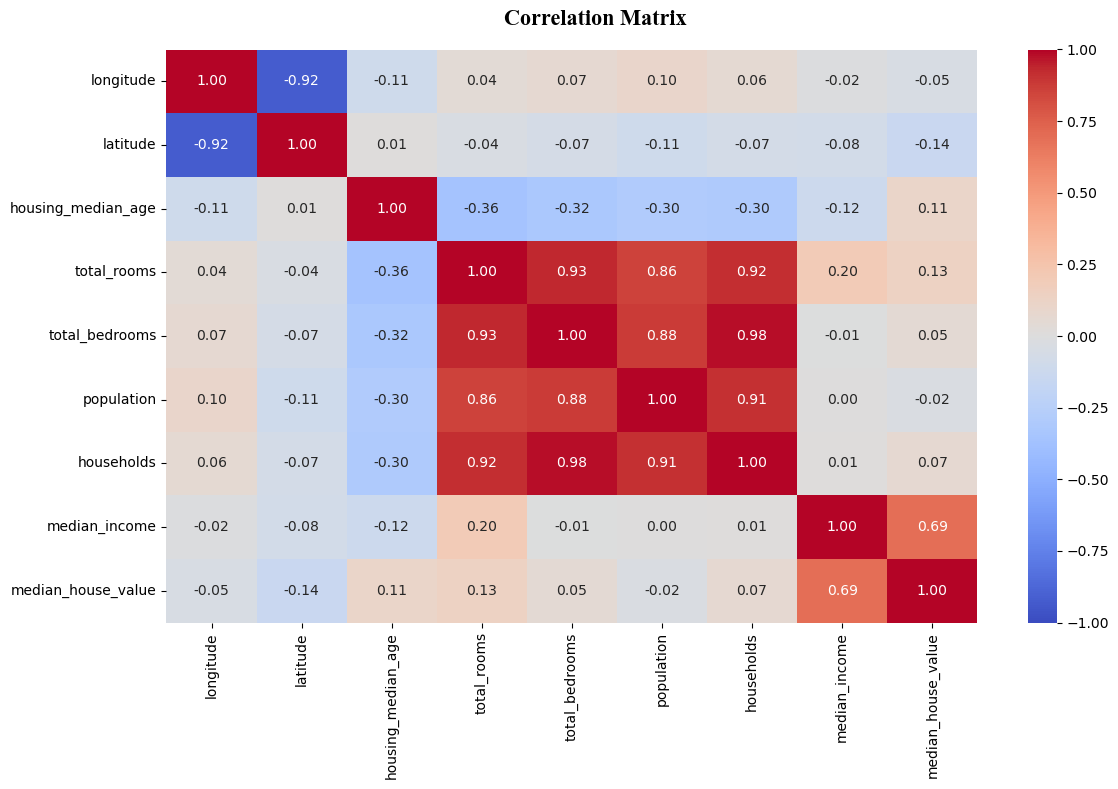

Correlation matrix saved as 'correlation_matrix.png'.

====== MISSING VALUES SUMMARY ======


,missing_count,total_count,missing_percentage
total_bedrooms,207,20640,1.002907



====== Categorical Features Summary ======
====== Categorical Feature: ocean_proximity ======


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

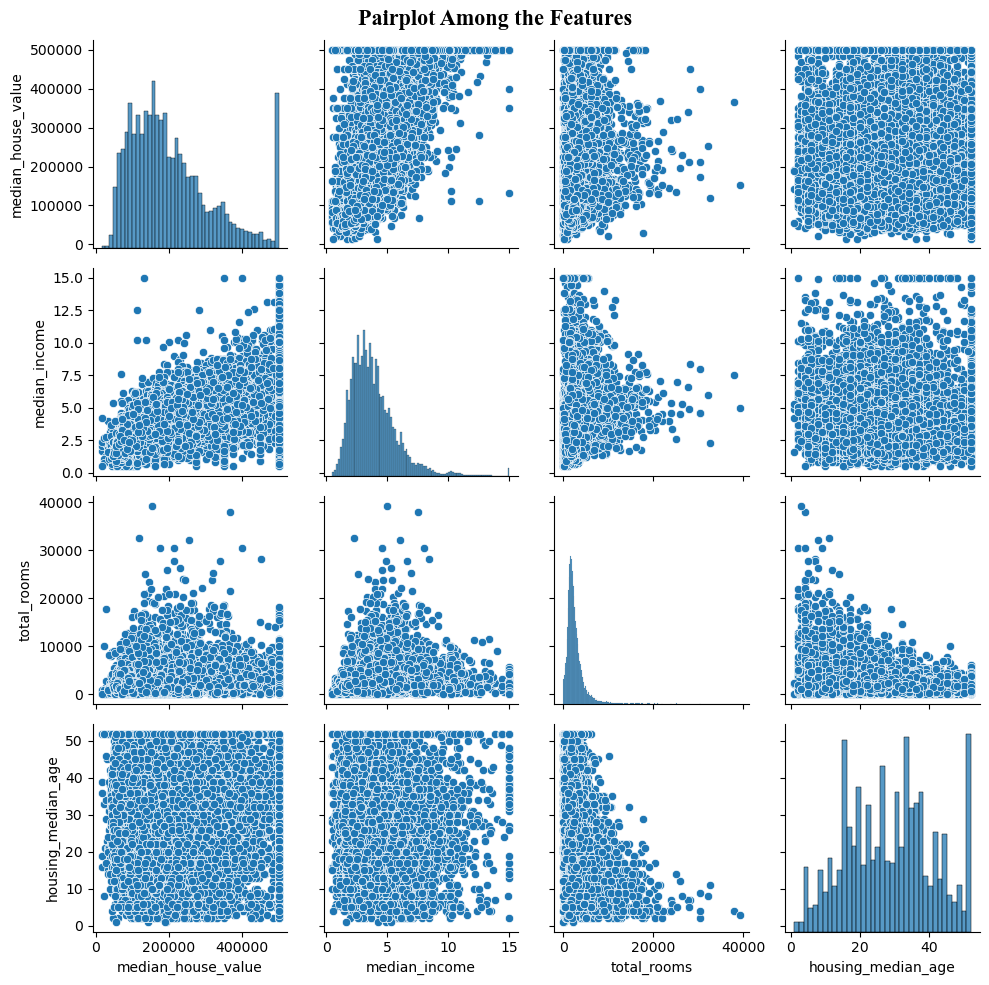

Pairplot saved as 'scatter_matrix.png'.


In [29]:
explorer = DataExplorer(housing_data)
explorer.summary_data()      
explorer.plot_histograms()    
explorer.correlation_matrix(save_fig=True) 
explorer.corr_mat["median_house_value"].sort_values(ascending=False)
explorer.missing_values_summary()  
explorer.categorical_summary()
explorer.pairplot(features=["median_house_value","median_income","total_rooms","housing_median_age"])

## Analysis of the data before preprocessing

median income is scaled down and capped at 15.0001 for higher median incomes and 0.5 at lower median incomes.
Similarly,Housing median age and median house value(capped at 50,000) were capped in the original data. 

Total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. 

The median housing prices histogram is skewed. So, a logarithmic transformation can be applied.

Also, Since the most of the features of the training data are of different scales, applying standardization would resolve the problem.

## Preprocessing of the data

In [30]:
class Preprocessing():
    """
    Function:
        A class for performing preprocessing tasks on a pandas DataFrame, including:
    handling missing values, encoding categorical variables, splitting data..

    Parameters
        dataframe : pd.DataFrame
            The dataset to be preprocessed.

    Attributes
        df : pd.DataFrame
            The original dataset provided during initialization.
        numeric_df : pd.DataFrame
            A subset of the DataFrame containing only numeric columns.
        categorical_df : pd.DataFrame
            A subset of the DataFrame containing only categorical columns.
    """
    def __init__(self,dataframe:pd.DataFrame)->pd.DataFrame:
        self.df=dataframe
    
    def seperate_numeric_categorical(self)->Union[pd.DataFrame,pd.DataFrame]:
        """
        Separates numeric and categorical features from the dataset.

        Returns
        -------
        tuple
            A tuple containing two DataFrames:
                Numeric DataFrame (`numeric_df`)
                Categorical DataFrame (`categorical_df`)
        """
        self.numeric_df=self.df.select_dtypes(include=["number"])
        self.categorical_df=self.df.select_dtypes(include=["object","category"])
        return self.numeric_df,self.categorical_df
        
    def simple_imputer(self,columns:Union[List[str],str]=None,
                       strategy:str="median",
                       fill_value: Optional[Union[str, int, float]]=None)-> pd.DataFrame:
        """
        Function:
          Missing values in the specified columns using a given strategy.

        Parameters:
        columns : list of str or str, optional
            The columns to impute. If None, all columns are considered.
        strategy : str, default='median'
            The imputation strategy ('mean', 'median', 'most_frequent', 'constant').
        fill_value : str, int, or float, optional
            The value to fill if `strategy='constant'`.

        Returns:
        pd.DataFrame
            The DataFrame with imputed values.
        """

        if columns is None:
            columns=self.df.columns
        elif isinstance(columns,str):
            columns=[columns]
        imputer=SimpleImputer(strategy=strategy,
                              fill_value=fill_value)
        self.imputed_data=imputer.fit_transform(self.df[columns])
        self.df[columns]=self.imputed_data
        return self.df
   
    def split_train_test_data(self,dataframe=None,test_ratio=0.2,random_state=42):
        """
        Function:
            Splits the dataset into training and testing sets.

        Parameters:
            dataframe : pd.DataFrame, optional
                The dataset to split. If None, uses the initialized DataFrame.
            test_ratio : float, default=0.2
                The proportion of the dataset to include in the test split.
            random_state : int, default=42
                Controls the shuffling applied before splitting.

        Returns:
            tuple of (train_data,test_data) of (pd.DataFrame,pd.DataFrame)
        """
        if dataframe is None:
            dataframe=self.df
        np.random.seed(random_state)
        indices=np.random.permutation(len(dataframe))
        random_data=self.df.iloc[indices]
        test_length=int(len(dataframe)*test_ratio)
        test_data=random_data[:test_length]
        train_data=random_data[test_length:]
        return train_data,test_data
    
    def convert_discrete_feature(self,continuous_feature:str,
                                 bins:List[float],
                                 labels:List[str],
                                 show_dirscete_hist: bool=True):
       
        """
        Function:
            Converts continuous features into discrete categories using binning.

        Parameters:
            continuous_feature : str
                The name of the continuous feature to convert.
            bins : list of float
                The bin edges to use for discretization.
            labels : list of str
                The labels for the bins.
            show_discrete_hist : bool, default=True
                Whether to plot a histogram of the discrete categories.

        Returns
            pd.DataFrame
                The DataFrame with the new discrete feature.
        """
        self.df["discrete_cat"]=pd.cut(
                                        self.df[continuous_feature],
                                        bins=bins,
                                        labels=labels)
        if show_dirscete_hist:
            self.df["discrete_cat"].hist()
            plt.title("Histogram for discrete data")
        return self.df
   
    def stratified_split(self, preserve_feature: str,
                         test_ratio: float = 0.2,
                         random_state: int = 42) -> Union[pd.DataFrame, pd.DataFrame]:
        """
        Function:
            Splits the data into training and testing sets while preserving the distribution
        of categories in the specified feature.

        Parameters:

        preserve_feature : str
            The feature whose distribution should be preserved during the split.
        test_ratio : float, default=0.2
            The proportion of the dataset to include in the test split.
        random_state : int, default=42
            Controls the shuffling applied before splitting.

        Returns
            tuple of (stratified_train_data,stratified_test_data) of (pd.DataFrame,pd.DataFrame)
        """
        stratified_train_data,stratified_test_data=pd.DataFrame(),pd.DataFrame()
        
        for each_cat in self.df[preserve_feature].unique():
            cat_data=self.df[self.df[preserve_feature]==each_cat]
            cat_train_data,cat_test_data=self.split_train_test_data(cat_data,test_ratio=test_ratio,random_state=random_state)
            stratified_train_data=pd.concat([stratified_train_data,cat_train_data])
            stratified_test_data=pd.concat([stratified_test_data,cat_test_data])
        return stratified_train_data,stratified_test_data
   
    def encode(self, categorical_features: Union[List[str], str] = None,
               with_strategy: str = "OneHotEncoding") -> pd.DataFrame:
        """
        Function:
            Encodes categorical features using the specified encoding strategy.

        Parameters:

            categorical_features : list of str or str, optional
                The features to encode. If None, all categorical features are considered.
            with_strategy : str, default='OneHotEncoding'
                The encoding strategy ('OneHotEncoding' supported).

        Returns:
            pd.DataFrame
                The DataFrame with encoded features.
        """
        if categorical_features is None:
            categorical_features=self.categorical_df.tolist()
        elif isinstance(categorical_features,str):
            categorical_features=[categorical_features]
        
        if with_strategy=="OneHotEncoding":
            
            cat_encoder=OneHotEncoder()
            hot_encoder_arr=cat_encoder.fit_transform(self.categorical_df[categorical_features].values.reshape(-1,1)).toarray()
            cat_df=pd.DataFrame(hot_encoder_arr,columns=cat_encoder.get_feature_names_out(),
                               index=self.df.index)
            
            # drop the origional categories features from the dataframe
            self.df.drop(columns=categorical_features,inplace=True)
            
            # concatenate the encoded features to the dataframe
            self.df=pd.concat([self.df,cat_df],axis=1)
            
            return self.df
            
    def drop_features(self, drop_feature: Union[str, List[str]],
                      dataframes: Union[List[pd.DataFrame], pd.DataFrame] = None) -> Union[pd.DataFrame, List[pd.DataFrame]]:
        """
        Function:
            Drops specified features from one or multiple DataFrames.

        Parameters:
            drop_feature : str or list of str
                The feature(s) to drop from the DataFrame(s).
            dataframes : pd.DataFrame or list of pd.DataFrame, optional
                The DataFrame(s) to process. If None, uses the initialized DataFrame.

        Returns:
            pd.DataFrame or list of pd.DataFrame
                The modified DataFrame(s) with the specified features dropped.
        """
        dropped_dfs=[]
        # If dataframes is not provided, use the instance's dataframes
        if dataframes is None:
            dataframes = self.df

        if isinstance(dataframes, pd.DataFrame):
            dataframes = [dataframes]
        
        # dropping the feature (i.e, income category) from the dataframes
        for idx,df in enumerate(dataframes):
            # Drop the feature and append the modified DataFrame to the list
            modified_df = df.drop(drop_feature, axis=1)
            dropped_dfs.append(modified_df)
        
        # Return a single DataFrame if only one was processed
        if len(dropped_dfs) == 1:
            return dropped_dfs[0]
            
        return dropped_dfs

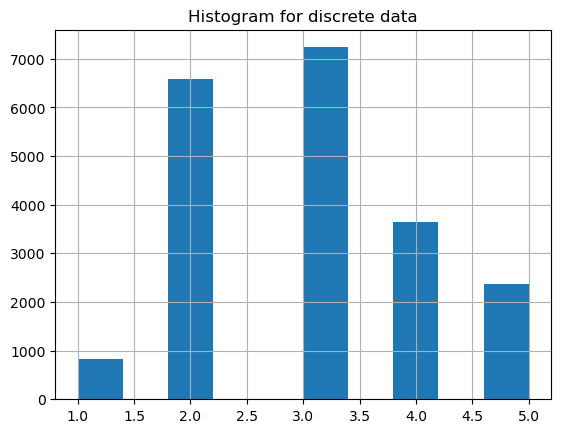

In [31]:
preprocessor=Preprocessing(housing_data)

#Seperating data into numeric and categorical datatypes
numeric_df,categorical_df=preprocessor.seperate_numeric_categorical()

# Impututation the nan values:
preprocessor.simple_imputer(columns=numeric_df.columns.tolist(),strategy="median",fill_value=None)

#creating a income category based on the median income, as it is important to have equal proportion in the training data as the collected data
df_with_income_cat=preprocessor.convert_discrete_feature(continuous_feature="median_income",bins=[0,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

# Encoding the categorical variables with one hot encoder
# encoded_data=preprocessor.encode(categorical_features="ocean_proximity",with_strategy="OneHotEncoding")

# Splitting the data into train and test data based on the proportionality of income category
strat_train,strat_test=preprocessor.stratified_split(preserve_feature="discrete_cat",test_ratio=0.2,random_state=42)
df_with_income_cat["discrete_cat"].value_counts()/len(df_with_income_cat)

train_data,test_data=preprocessor.drop_features(drop_feature=["discrete_cat","ocean_proximity"],dataframes=[strat_train,strat_test])

In [32]:
y_test_act=test_data["median_house_value"]

In [33]:
test_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1138,-121.56,39.69,8.0,2836.0,522.0,1163.0,512.0,3.1300,168300.0
1628,-122.18,37.86,33.0,4449.0,636.0,1684.0,617.0,8.9571,399700.0
1606,-122.08,37.88,26.0,2947.0,435.0,825.0,626.0,2.9330,85000.0
1976,-120.59,38.53,15.0,432.0,87.0,208.0,73.0,3.6125,100000.0
1526,-122.08,37.89,39.0,3018.0,501.0,1223.0,489.0,6.2924,283900.0
...,...,...,...,...,...,...,...,...,...
570,-122.24,37.72,5.0,18634.0,2885.0,7427.0,2718.0,7.6110,350700.0
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0
211,-122.22,37.79,52.0,3424.0,690.0,2273.0,685.0,3.9048,164700.0
448,-122.28,37.87,46.0,3022.0,696.0,1293.0,675.0,2.5430,220700.0


In [34]:
# Set median house value as the target feature
y_train=train_data["median_house_value"]

# Set  sampleds of remaining features as training and test data dropping median house value
X_train,X_test=preprocessor.drop_features(drop_feature="median_house_value",
                dataframes=[train_data,test_data])

# Standardizing the data
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
# Applying log transformation to handle outliers in target variable
y_train = np.log1p(y_train)

In [35]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-0.995816,0.663889,0.110770,-0.458329,-0.346968,-0.270393,-0.324055,-0.558745
1,0.192964,0.241139,0.110770,-0.503126,-0.640542,-0.845331,-0.612039,0.329743
2,0.078758,1.290555,-0.669693,-0.762010,-0.680215,-0.854425,-0.770148,-1.002963
3,0.177391,0.246113,-0.279462,-0.082764,-0.442181,-0.584639,-0.397462,0.872524
4,-1.099640,0.763360,0.735140,-0.110892,0.123809,-0.118828,0.274501,-0.705115
...,...,...,...,...,...,...,...,...
16509,-1.104831,0.738492,1.125371,-0.777116,-0.545329,-0.756413,-0.547101,-1.524315
16510,-1.078875,0.738492,1.593649,-0.208821,-0.056039,-0.628087,-0.041717,-0.184816
16511,-1.047728,0.723572,0.110770,-1.190185,-1.248849,-0.763486,-1.196477,0.132302
16512,-1.110022,0.773307,1.047325,-1.028187,-0.944696,-0.587670,-0.942374,-1.131327


## Geographical visualization of the housing prices(by color) and density of population (by marker size)


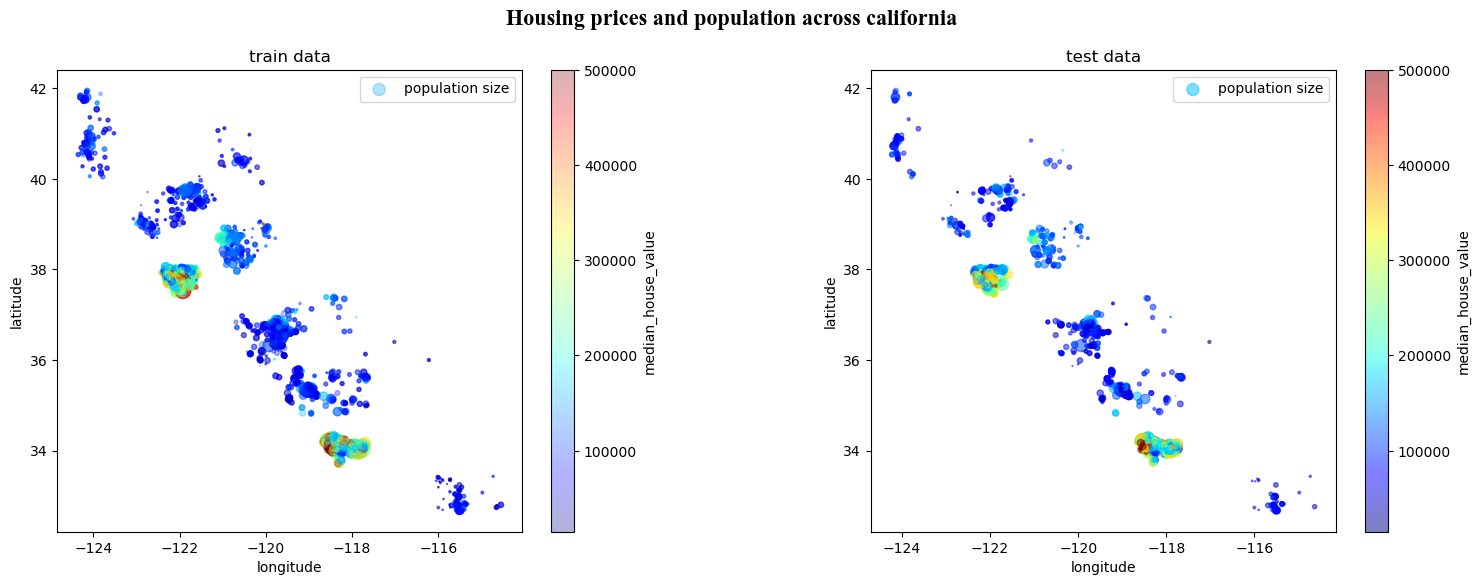

In [36]:
def geographical_visualization(train_data: pd.DataFrame, 
                               test_data: pd.DataFrame, 
                               save_fig: bool = True) -> None:
    """
    Function: 
        Visualizes the geographical distribution of housing prices and population 
        across California using scatter plots for both training and testing datasets.

    Parameters:
        train_data : pd.DataFrame
            The training dataset containing features like 'longitude', 'latitude', 
            'median_house_value', and 'population'.

        test_data : pd.DataFrame
            The testing dataset containing similar features as the training dataset.

        save_fig : bool, optional (default=True)
            If True, saves the generated figure as an image file named 
            "housing prices and population of california.png".

    Returns:
        None
            The function does not return any value. It generates and optionally 
            saves a plot visualizing housing prices and population distribution.
    """
    fig,axis=plt.subplots(1,2,figsize=(18,6))
    
    for index in range(len(axis)):
        axis[index].set(xlabel="longitude",ylabel="latitude")
    
    train_data.plot(x="longitude",y="latitude",kind="scatter",ax=axis[0],
                         title="train data",alpha=0.3,c="median_house_value",
                         cmap="jet",s=train_data["population"]/100,
                         label="population size")
    test_data.plot(x="longitude",y="latitude",kind="scatter",ax=axis[1],
                       title="test data",alpha=0.5,c="median_house_value",
                         cmap="jet",s=test_data["population"]/100,
                        label="population size") 
    fig.suptitle("Housing prices and population across california",fontname="Times New Roman",fontweight='bold',
                fontsize=16)
    plt.legend()

    plt.subplots_adjust(top=0.88, wspace=0.4)
    
    if save_fig:
        fig.savefig("housing prices and population of california")

    plt.show()
geographical_visualization(train_data,test_data,save_fig=True)

From visual inspection of the data, It can be inferred that majority of the population resides at the bay area,probably resulting in high housing prices.


Since other features of nan-bedrooms rows does contribute significantly to median house value,
we replace the nan with median of the columns.

The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms.

The number of rooms per household is also more informative than the total number of rooms in a
district—obviously the larger the houses, the more expensive they are.

## Selection of the best model through cross validation

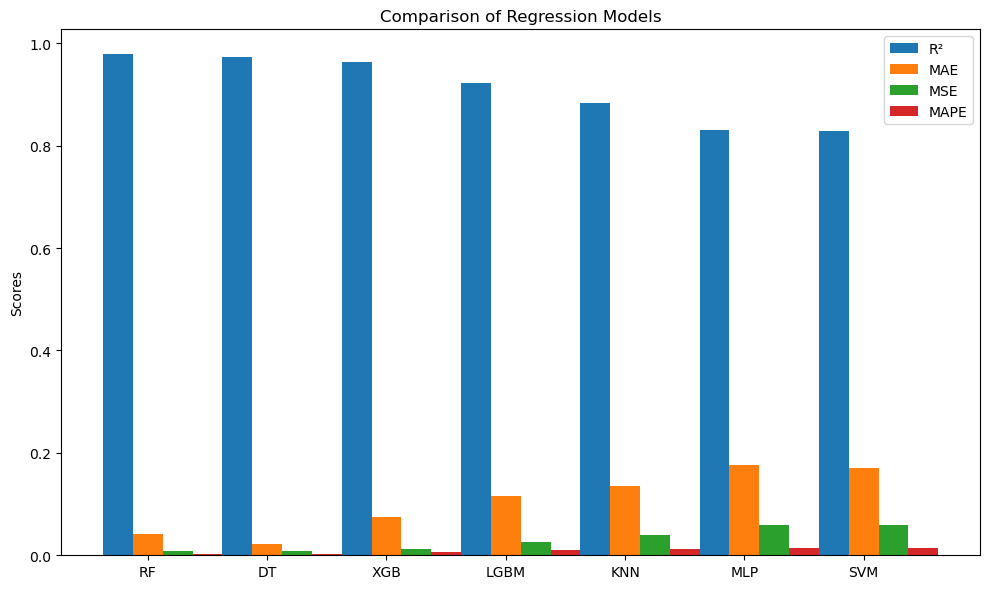

In [37]:


class ModelSelection():
    """
    A class for comparing multiple regression models using cross-validation 
    and visualizing performance metrics such as R², MAE, MSE, and MAPE.

    Parameters
        regressors : dict, optional
            A dictionary containing custom regressors with model names as keys 
            and regressor instances as values. 
            If None, default models (KNN, DT, RF, SVM, MLP, XGB, LGBM) are used.

    Attributes
        regressors : dict
            A dictionary of regression models for evaluation.
        metrics_dict : pd.DataFrame
            A DataFrame containing evaluation metrics for all models after cross-validation.
    """

    def __init__(self, regressors: Optional[Dict[str, object]] = None):
        self.regressors = {
            "KNN": KNeighborsRegressor(),
            "DT": DecisionTreeRegressor(),
            "RF": RandomForestRegressor(),
            "SVM": SVR(),
            "MLP": MLPRegressor(),
            "XGB": XGBRegressor(),
            "LGBM": LGBMRegressor()
        } if regressors is None else regressors

    def cross_validation(self, 
                         X_train: pd.DataFrame, 
                         y_train: Union[pd.Series, np.ndarray], 
                         cv: int,
                         scoring: List[str] = ["neg_mean_absolute_error", 
                                               "neg_mean_squared_error", 
                                               "r2", 
                                               "neg_mean_absolute_percentage_error"],
                         n_jobs: int = 2) -> pd.DataFrame:
        """
        Function:
            Performs cross-validation on the provided regression models and computes evaluation metrics.

        Parameters:
            X_train : pd.DataFrame
                The feature set for training the models.

            y_train : pd.Series or np.ndarray
                The target variable corresponding to the features.

            cv : int
                Number of cross-validation folds.

            scoring : list of str, optional
                List of scoring metrics to evaluate models. Default includes:
                'neg_mean_absolute_error' (MAE)
                'neg_mean_squared_error' (MSE)
                'r2' (R² Score)
                'neg_mean_absolute_percentage_error' (MAPE)

            n_jobs : int, optional (default=2)
                Number of CPU cores to use for parallel processing. 
        Returns:
            pd.DataFrame
                A DataFrame containing average evaluation metrics (R², MAE, MSE, MAPE)
                for each model, sorted by R² score in descending order.
        """
        results_list = []
        for name, model in self.regressors.items():
            cv_results = cross_validate(
                model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=n_jobs
            )
            df = pd.DataFrame({
                "regressor": [name],
                "avg_r2": np.abs([np.mean(cv_results["test_r2"])]),
                "avg_MAE": np.abs([np.mean(cv_results["test_neg_mean_absolute_error"])]),
                "avg_MSE": np.abs([np.mean(cv_results["test_neg_mean_squared_error"])]),
                "avg_MAPE": np.abs([np.mean(cv_results["test_neg_mean_absolute_percentage_error"])]),
            })
            results_list.append(df)

        sorted_results = pd.concat(results_list)
        self.metrics_dict = sorted_results.sort_values(by=["avg_r2"], ascending=False, ignore_index=True)
        return self.metrics_dict

    def plot_model_comparisions(self) -> None:
        """
        Function:
        Plots bar charts to compare regression models based on 
        R², MAE, MSE, and MAPE scores from the cross-validation results.

        Returns:                
            Displays a bar plot comparing the performance of each model.
        """
        labels = self.metrics_dict['regressor']
        r2 = self.metrics_dict['avg_r2']
        mae = self.metrics_dict['avg_MAE']
        mse = self.metrics_dict['avg_MSE']
        mape = self.metrics_dict['avg_MAPE']

        x = np.arange(len(labels))  
        width = 0.25                

        fig, ax = plt.subplots(figsize=(10, 6))

        # Plotting bars for R², MAE, MSE, MAPE
        bars_r2 = ax.bar(x - width, r2, width, label='R²')
        bars_mae = ax.bar(x, mae, width, label='MAE')
        bars_mse = ax.bar(x + width, mse, width, label='MSE')
        bars_mape = ax.bar(x + 2 * width, mape, width, label='MAPE')

        # Annotating the x-axis tick labels, title, and ylabel
        ax.set_ylabel('Scores')
        ax.set_title('Comparison of Regression Models')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        plt.tight_layout()
        plt.show()

model_selector=ModelSelection()
model_selector.cross_validation(X_train,y_train,cv=5,
                              scoring=["neg_mean_absolute_error",
                                "neg_mean_squared_error",
                                "r2",
                                "neg_mean_absolute_percentage_error"],n_jobs=4)
model_selector.plot_model_comparisions()

In [38]:
model_selector.metrics_dict

,regressor,avg_r2,avg_MAE,avg_MSE,avg_MAPE
0,RF,0.978376,0.041100,0.007559,0.003428
1,DT,0.973528,0.022064,0.009294,0.001829
2,XGB,0.963656,0.075530,0.012620,0.006322
3,LGBM,0.923047,0.116107,0.026599,0.009724
4,KNN,0.883442,0.135283,0.040332,0.011328
5,MLP,0.830212,0.175437,0.058628,0.014681
6,SVM,0.829692,0.170697,0.058807,0.014315


Random forest regressor performs well for th given housing data exhibiting very low mean square error and low absolute error.

XGB does have a marginally higher R 
2, but its MAE and MAPE are higher than Random foreset regression-suggesting some points poorly.

Decision Tree(DT) also has a high R2, but there are many large percentage errors indicating large percentage errors.

Remaining methods LGBM,KNN, MLP,SVM has lower R2 and large errors.

## Predicting the median house values using the best model

In [39]:
rf_reg=RandomForestRegressor()
rf_reg.fit(X_train,y_train)
y_pred_logs=rf_reg.predict(X_test)
# Converting back to original units from logarithmic values
y_pred=np.expm1(y_pred_logs)

In [40]:
pd.DataFrame({"Actual_house_prices($)":y_test_act,
              "Predicted_house_prices($)":y_pred
              })

,Actual_house_prices($),Predicted_house_prices($)
1138,168300.0,165422.621735
1628,399700.0,402335.581671
1606,85000.0,156579.988413
1976,100000.0,100465.275210
1526,283900.0,284079.866163
...,...,...
570,350700.0,353219.166945
290,161900.0,167394.016565
211,164700.0,177184.058942
448,220700.0,219384.742708


In [49]:
#accuracy of the model
r2=r2_score(y_test_act,y_pred)
r2

0.9639415748010067